In [1]:
!conda install -c anaconda sqlalchemy

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

#Shows float values with commas
pd.options.display.float_format = '{:,}'.format

## SQLAlchemy

In [3]:
from sqlalchemy import create_engine
engine = create_engine("sqlite:///C:\\Users\\jayju\\Desktop\\Metis\\MTA Project\\SQL\\MTA_Raw_Data_6Mo v3.db")

engine.table_names()

<ipython-input-3-c71a3373cb40>:4: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  engine.table_names()


['post_covid', 'pre_covid', 'station_locations']

### Read the pre-covid data via SQLAlchemy

In [4]:
#Data set is from Mar 2, 2019 - Sep 28, 2019 (30 weeks of data)
df_pre = pd.read_sql('SELECT * FROM pre_covid' , engine)
df_pre.head()


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Borough
0,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,03/02/2019,01:00:00,REGULAR,3758261,6444610,M
1,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,03/02/2019,05:00:00,REGULAR,3758275,6444624,M
2,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,03/02/2019,09:00:00,REGULAR,3758310,6444811,M
3,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,03/02/2019,13:00:00,REGULAR,3758378,6445249,M
4,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,03/02/2019,17:00:00,REGULAR,3758617,6445578,M


### Read the post-covid data via SQLAlchemy

In [5]:
#Data set is from Feb 27 - Sep 25, 2021 (30 weeks of data)
df_post = pd.read_sql('SELECT * FROM post_covid;' , engine)
df_post.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Borough
0,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,02/27/2021,01:00:00,REGULAR,4414499,7600574,M
1,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,02/27/2021,05:00:00,REGULAR,4414502,7600578,M
2,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,02/27/2021,09:00:00,REGULAR,4414518,7600690,M
3,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,02/27/2021,13:00:00,REGULAR,4414549,7600900,M
4,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,02/27/2021,17:00:00,REGULAR,4414646,7601035,M


# Pre-Covid Data Code
This will be the section for the code that works on the pre-covid data. 

### Part 1: Initial data scrubbing
These sections of code will scrub the data for:
- Checking spelling and spacing in columns are accurate
- Checking all types in the dataframe are accurate
- Checking there are no duplicate entries in the data set

In [6]:
#Checking columns and cleaning up labels
df_pre.columns = [column.strip() for column in df_pre.columns]
df_pre.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'Borough'],
      dtype='object')

In [7]:
#Checking data types
df_pre.dtypes

C/A         object
UNIT        object
SCP         object
STATION     object
LINENAME    object
DIVISION    object
DATE        object
TIME        object
DESC        object
ENTRIES      int64
EXITS        int64
Borough     object
dtype: object

In [8]:
#Converting Date to type datetime and Entries to type float (so it can have commas)
df_pre['DATE'] = pd.to_datetime(df_pre['DATE'])
df_pre['ENTRIES'] = df_pre['ENTRIES'].astype(float)

df_pre.dtypes

C/A                 object
UNIT                object
SCP                 object
STATION             object
LINENAME            object
DIVISION            object
DATE        datetime64[ns]
TIME                object
DESC                object
ENTRIES            float64
EXITS                int64
Borough             object
dtype: object

In [9]:
#Preview data after initial scrub
df_pre.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Borough
0,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,2019-03-02,01:00:00,REGULAR,"3,758,261.0",6444610,M
1,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,2019-03-02,05:00:00,REGULAR,"3,758,275.0",6444624,M
2,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,2019-03-02,09:00:00,REGULAR,"3,758,310.0",6444811,M
3,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,2019-03-02,13:00:00,REGULAR,"3,758,378.0",6445249,M
4,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,2019-03-02,17:00:00,REGULAR,"3,758,617.0",6445578,M


In [10]:
#Checking for duplicates in the data
df_pre.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE']).ENTRIES.count().reset_index().sort_values('ENTRIES', ascending=False)

#Drop duplicates
df_pre.drop_duplicates(subset=['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'], inplace=True)

### Part 2: Calculate the daily entries per station
This section will create a new column in the dataframe that will calculate the daily entries for each turnstile/station (NOTE: We are using 'DATE' and not 'DATE_TIME'). 

To do so, we first create a new column called 'PREV_ENTRIES' that holds the entries from the previous day. Daiy Entries is then calculated by finding the difference between ENTRIES and PREV_ENTRIES.

In [22]:
#Create new dataframe that will group by turnstile and date. Of note, we also group by LINENAME because some stations are 
#labeled the same 
pre_daily_turnstile = df_pre.groupby(['C/A', 'UNIT', 'SCP', 'STATION' , 'LINENAME' , 'DATE'], as_index = False).agg({'ENTRIES' : 'sum' , 'Borough' : 'first'})
pre_daily_turnstile.head()


,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,Borough
0,A006,R079,00-00-00,5 AV/59 ST,NQRW,2019-03-02,"3,758,261.0",M
1,A006,R079,00-00-00,5 AV/59 ST,NQRW,2019-03-03,"3,759,045.0",M
2,A006,R079,00-00-00,5 AV/59 ST,NQRW,2019-03-04,"3,759,690.0",M
3,A006,R079,00-00-00,5 AV/59 ST,NQRW,2019-03-05,"3,761,124.0",M
4,A006,R079,00-00-00,5 AV/59 ST,NQRW,2019-03-06,"3,762,715.0",M


In [23]:
#Create a new column that records the previous day's entries
pre_daily_turnstile[['PREV_DATE', 'PREV_ENTRIES']] = pre_daily_turnstile.groupby(['STATION'])['DATE', 'ENTRIES'].apply(lambda grp: grp.shift(1))

#Drop the rows for the earliest date in the dataframe
pre_daily_turnstile.dropna(subset=['PREV_DATE'], axis=0, inplace=True)

pre_daily_turnstile.head()

<ipython-input-23-70495b24cb12>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pre_daily_turnstile[['PREV_DATE', 'PREV_ENTRIES']] = pre_daily_turnstile.groupby(['STATION'])['DATE', 'ENTRIES'].apply(lambda grp: grp.shift(1))


,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,Borough,PREV_DATE,PREV_ENTRIES
1,A006,R079,00-00-00,5 AV/59 ST,NQRW,2019-03-03,"3,759,045.0",M,2019-03-02,"3,758,261.0"
2,A006,R079,00-00-00,5 AV/59 ST,NQRW,2019-03-04,"3,759,690.0",M,2019-03-03,"3,759,045.0"
3,A006,R079,00-00-00,5 AV/59 ST,NQRW,2019-03-05,"3,761,124.0",M,2019-03-04,"3,759,690.0"
4,A006,R079,00-00-00,5 AV/59 ST,NQRW,2019-03-06,"3,762,715.0",M,2019-03-05,"3,761,124.0"
5,A006,R079,00-00-00,5 AV/59 ST,NQRW,2019-03-07,"3,764,345.0",M,2019-03-06,"3,762,715.0"


In [26]:
def entry_check(row, max_entries):
    entries_today = row['ENTRIES'] - row['PREV_ENTRIES']
    if entries_today < 0:
        
        #Sets it to the positive entry
        entries_today = -entries_today
        
    if entries_today > max_entries:
        
        #Shows any turnstiles that have reset and sets the new entries of that day to the minimum of 'ENTRIES' or 'PREV_ENTRIES'
        entries_today = min(row['ENTRIES'] , row['PREV_ENTRIES'])
        
    if entries_today > max_entries:
        return 0
    return entries_today

In [27]:
#Create the column DAILY_ENTRIES that shows what the daily entries per station per date are.
#entry_check based on max_entries of 86,400 / day, or approximately 60 persons per minute  per turnstile
pre_daily_turnstile['DAILY_ENTRIES'] = pre_daily_turnstile.apply(entry_check, axis = 1, max_entries = 86400)
pre_daily_turnstile.head(10)


,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,Borough,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A006,R079,00-00-00,5 AV/59 ST,NQRW,2019-03-03,"3,759,045.0",M,2019-03-02,"3,758,261.0",784.0
2,A006,R079,00-00-00,5 AV/59 ST,NQRW,2019-03-04,"3,759,690.0",M,2019-03-03,"3,759,045.0",645.0
3,A006,R079,00-00-00,5 AV/59 ST,NQRW,2019-03-05,"3,761,124.0",M,2019-03-04,"3,759,690.0","1,434.0"
4,A006,R079,00-00-00,5 AV/59 ST,NQRW,2019-03-06,"3,762,715.0",M,2019-03-05,"3,761,124.0","1,591.0"
5,A006,R079,00-00-00,5 AV/59 ST,NQRW,2019-03-07,"3,764,345.0",M,2019-03-06,"3,762,715.0","1,630.0"
6,A006,R079,00-00-00,5 AV/59 ST,NQRW,2019-03-08,"3,765,987.0",M,2019-03-07,"3,764,345.0","1,642.0"
7,A006,R079,00-00-00,5 AV/59 ST,NQRW,2019-03-09,"3,767,541.0",M,2019-03-08,"3,765,987.0","1,554.0"
8,A006,R079,00-00-00,5 AV/59 ST,NQRW,2019-03-10,"3,768,406.0",M,2019-03-09,"3,767,541.0",865.0
9,A006,R079,00-00-00,5 AV/59 ST,NQRW,2019-03-11,"3,768,954.0",M,2019-03-10,"3,768,406.0",548.0
10,A006,R079,00-00-00,5 AV/59 ST,NQRW,2019-03-12,"3,770,567.0",M,2019-03-11,"3,768,954.0","1,613.0"


In [28]:
#Sanity check. Code pulls 5 random stations and a random # of rows from those five stations 
#to check there are no outliers in DAILY_ENTRIES
filter = pre_daily_turnstile['STATION'].sample(n=10)
mask = pre_daily_turnstile['STATION'].isin(filter) 
pre_daily_turnstile[mask].sample(n=50).sort_values(by=['STATION'])

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,Borough,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
196827,N022,R332,02-05-01,135 ST,BC,2019-07-01,"524,288.0",M,2019-06-30,"524,288.0",0.0
197749,N023,R332,01-00-01,135 ST,BC,2019-09-21,"5,415.0",M,2019-09-20,"5,051.0",364.0
665705,R307,R207,01-00-01,135 ST,23,2019-03-28,"325,778.0",M,2019-03-27,"324,712.0","1,066.0"
665898,R307,R207,01-00-02,135 ST,23,2019-03-17,"6,681,741.0",M,2019-03-16,"6,680,851.0",890.0
546236,R161B,R452,00-03-01,72 ST,123,2019-09-15,"809,525.0",M,2019-09-14,"807,208.0","2,317.0"
213015,N046,R281,00-06-00,72 ST,BC,2019-08-15,"334,001.0",M,2019-08-14,"332,555.0","1,446.0"
545234,R161B,R452,00-00-01,72 ST,123,2019-04-06,"11,953,911.0",M,2019-04-05,"11,952,145.0","1,766.0"
543515,R161A,R452,01-00-01,72 ST,123,2019-04-22,"5,423,448.0",M,2019-04-21,"5,422,575.0",873.0
546551,R161B,R452,00-03-03,72 ST,123,2019-06-02,"18,455,951.0",M,2019-06-01,"18,453,612.0","2,339.0"
212375,N046,R281,00-00-02,72 ST,BC,2019-08-05,"9,536,449.0",M,2019-08-04,"9,535,776.0",673.0


### Part 3: Plot the data points
Using Python's visualization tools, show the most trafficked stations in NYC.

In [29]:
#Creating new dataframe based on only Station and Entries. Note that although the column is called DAILY_ENTRIES, it is the 
#total daily entries during this period.
pre_daily_station = pre_daily_turnstile.groupby(['STATION' , 'LINENAME'], as_index = False).agg({'DAILY_ENTRIES' : 'sum' , 'ENTRIES' : 'first' , 'Borough' : 'first'})
pre_daily_station.head(10)

,STATION,LINENAME,DAILY_ENTRIES,ENTRIES,Borough
0,1 AV,L,"3,109,217.0","14,471,608.0",M
1,103 ST,1,"2,091,736.0","1,798,471.0",M
2,103 ST,6,"2,316,813.0","36,655,681.0",M
3,103 ST,BC,"899,196.0","13,967,624.0",M
4,103 ST-CORONA,7,"3,677,694.0","15,470,589.0",Q
5,104 ST,A,"316,260.0","182,364.0",Q
6,104 ST,JZ,"458,263.0","6,026,022.0",Q
7,110 ST,6,"1,894,045.0","4,587,421.0",M
8,111 ST,7,"2,128,613.0","16,646,021.0",Q
9,111 ST,A,"451,492.0","50,331,790.0",Q


In [30]:
#Count # of stations that are considered 'tourist hotspots' (i.e. stations with major transfers)
pre_daily_station[pre_daily_station['LINENAME'].str.len() > 6].count()

STATION          9
LINENAME         9
DAILY_ENTRIES    9
ENTRIES          9
Borough          9
dtype: int64

In [31]:
#Filtering train stations in Manhattan that weren't caught by the 'tourist hotspot' filter
pre_daily_station.loc[(pre_daily_station['STATION'] == '34 ST-PENN STA') , 'LINENAME'] = 'PATH'
pre_daily_station.loc[(pre_daily_station['STATION'] == 'PATH NEW WTC') , 'LINENAME'] = 'PATH'
pre_daily_station.loc[(pre_daily_station['STATION'] == 'THIRTY THIRD ST') , 'LINENAME'] = 'PATH'
pre_daily_station.loc[(pre_daily_station['STATION'] == 'PAVONIA/NEWPORT') , 'LINENAME'] = 'PATH'

#Grand Central Station does not have a PATH stop but is still a major train station 
pre_daily_station.loc[(pre_daily_station['STATION'] == 'GRD CNTRL-42 ST') , 'LINENAME'] = 'PATH'

#Filtering PATH stations in New Jersey
pre_daily_station.loc[(pre_daily_station['STATION'] == 'NEWARK BM BW') , 'LINENAME'] = 'PATH'
pre_daily_station.loc[(pre_daily_station['STATION'] == 'NEWARK C') , 'LINENAME'] = 'PATH'
pre_daily_station.loc[(pre_daily_station['STATION'] == 'NEWARK HM HE') , 'LINENAME'] = 'PATH'
pre_daily_station.loc[(pre_daily_station['STATION'] == 'PAVONIA/NEWPORT	') , 'LINENAME'] = 'PATH'
pre_daily_station.loc[(pre_daily_station['STATION'] == 'NEWARK HW BMEBE') , 'LINENAME'] = 'PATH'
pre_daily_station.loc[(pre_daily_station['STATION'] == 'JOURNAL SQUARE') , 'LINENAME'] = 'PATH'
pre_daily_station.loc[(pre_daily_station['STATION'] == 'GROVE STREET') , 'LINENAME'] = 'PATH'
pre_daily_station.loc[(pre_daily_station['STATION'] == 'HARRISON') , 'LINENAME'] = 'PATH'
pre_daily_station.loc[(pre_daily_station['STATION'] == 'EXCHANGE PLACE') , 'LINENAME'] = 'PATH'

#Data set also includes aggregate bus data that which will be filtered out
pre_daily_station.loc[(pre_daily_station['STATION'] == 'CITY / BUS') , 'LINENAME'] = 'PATH'

#Filter out the data set with stations that aren't major tourist hubs, are not located in NJ, and are not bus routes
pre_daily_station_filtered = pre_daily_station[(pre_daily_station['LINENAME'].str.len() < 6) & (pre_daily_station['LINENAME'].ne('PATH'))]
pre_daily_station_filtered

,STATION,LINENAME,DAILY_ENTRIES,ENTRIES,Borough
0,1 AV,L,"3,109,217.0","14,471,608.0",M
1,103 ST,1,"2,091,736.0","1,798,471.0",M
2,103 ST,6,"2,316,813.0","36,655,681.0",M
3,103 ST,BC,"899,196.0","13,967,624.0",M
4,103 ST-CORONA,7,"3,677,694.0","15,470,589.0",Q
...,...,...,...,...,...
435,WOODLAWN,4,"1,260,838.0","8,072,385.0",Bx
436,WORLD TRADE CTR,ACE23,"3,423,013.0","497,148.0",M
437,WTC-CORTLANDT,1,"3,159,923.0",24.0,M
438,YORK ST,F,"2,335,001.0","14,861,686.0",Bk


In [32]:
#Create a second dataframe that stores the top 10 most trafficked stations
pre_MTA_Top25 = pre_daily_station_filtered.nlargest(25, 'DAILY_ENTRIES')
pre_MTA_Top25.head(25)

,STATION,LINENAME,DAILY_ENTRIES,ENTRIES,Borough
120,59 ST COLUMBUS,ABCD1,"10,704,229.0","2,919,917.0",M
104,47-50 STS ROCK,BDFM,"10,498,341.0","279,363.0",M
276,FLUSHING-MAIN,7,"10,410,452.0","9,155,212.0",Q
319,JKSN HT-ROOSVLT,EFMR7,"9,424,987.0","2,588,779.0",Q
150,86 ST,456,"7,796,712.0","2,608,920.0",M
98,42 ST-BRYANT PK,BDFM7,"7,608,385.0","1,830,631.0",M
132,72 ST,123,"7,463,459.0","145,691.0",M
158,96 ST,123,"6,778,498.0","1,328,840.0",M
117,57 ST-7 AV,NQRW,"6,449,788.0","4,133,252.0",M
315,JAMAICA CENTER,EJZ,"6,182,378.0","867,013.0",Q


In [33]:
#Calculate average of results
pre_MTA_Top25['DAILY_ENTRIES'].mean()

6335031.36

Text(0.5, 1.0, 'Top 25 Trafficked Stations in NYC - Pre Covid')

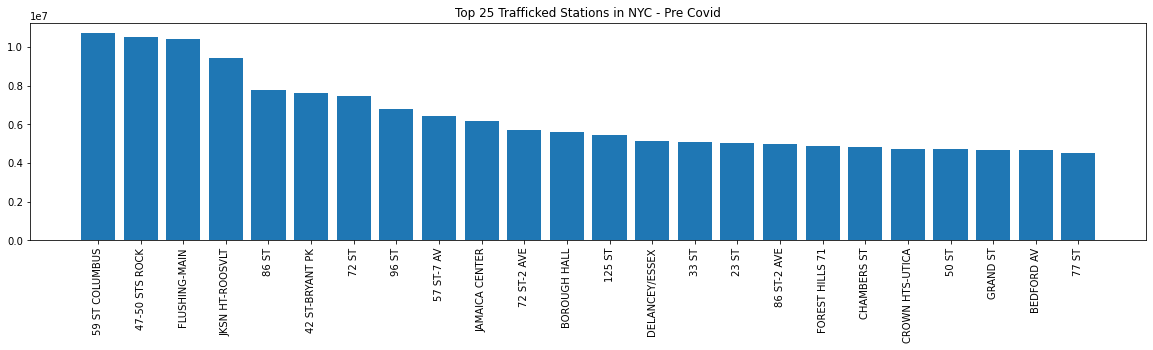

In [34]:
plt.figure(figsize=(20,4)) 


plt.xticks(rotation='vertical')
plt.bar(pre_MTA_Top25['STATION'], pre_MTA_Top25['DAILY_ENTRIES'])
plt.title('Top 25 Trafficked Stations in NYC - Pre Covid')

# Post-Covid Data Code
This will be the section for the code that works on the post-covid data (Code is essentially the same as pre-covid section).

### Part 1: Initial data scrubbing
These sections of code will scrub the data for:

- Checking spelling and spacing in columns are accurate
- Checking all types in the dataframe are accurate
- Checking there are no duplicate entries in the data set

In [35]:
#Checking columns and cleaning up labels
df_post.columns = [column.strip() for column in df_post.columns]
df_post.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'Borough'],
      dtype='object')

In [36]:
#Checking data types
df_post.dtypes

C/A         object
UNIT        object
SCP         object
STATION     object
LINENAME    object
DIVISION    object
DATE        object
TIME        object
DESC        object
ENTRIES      int64
EXITS        int64
Borough     object
dtype: object

In [37]:
#Converting Date to type datetime and Entries to type float (so it can have commas)
df_post['DATE'] = pd.to_datetime(df_post['DATE'])
df_post['ENTRIES'] = df_post['ENTRIES'].astype(float)

df_post.dtypes

C/A                 object
UNIT                object
SCP                 object
STATION             object
LINENAME            object
DIVISION            object
DATE        datetime64[ns]
TIME                object
DESC                object
ENTRIES            float64
EXITS                int64
Borough             object
dtype: object

In [76]:
#Preview data after initial scrub
df_post.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Borough
0,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,2021-02-27,01:00:00,REGULAR,"4,414,499.0",7600574,M
1,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,2021-02-27,05:00:00,REGULAR,"4,414,502.0",7600578,M
2,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,2021-02-27,09:00:00,REGULAR,"4,414,518.0",7600690,M
3,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,2021-02-27,13:00:00,REGULAR,"4,414,549.0",7600900,M
4,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,2021-02-27,17:00:00,REGULAR,"4,414,646.0",7601035,M


In [77]:
#Checking for duplicates in the data
df_post.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE']).ENTRIES.count().reset_index().sort_values('ENTRIES', ascending=False)

#Drop duplicates
df_post.drop_duplicates(subset=['C/A', 'UNIT', 'SCP', 'STATION', 'DATE'], inplace=True)

### Part 2: Calculate the daily entries per station
This section will create a new column in the dataframe that will calculate the daily entries for each turnstile/station (NOTE: We are using 'DATE' and not 'DATE_TIME'). 

To do so, we first create a new column called 'PREV_ENTRIES' that holds the entries from the previous day. Daiy Entries is then calculated by finding the difference between ENTRIES and PREV_ENTRIES.

In [78]:
#Create new dataframe that will group by turnstile and date
post_daily_turnstile = df_post.groupby(['C/A', 'UNIT', 'SCP', 'STATION' , 'LINENAME' , 'DATE'], as_index = False).agg({'ENTRIES' : 'sum' , 'Borough' : 'first'})
post_daily_turnstile.head()


,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,Borough
0,A006,R079,00-00-00,5 AV/59 ST,NQRW,2021-02-27,"4,414,499.0",M
1,A006,R079,00-00-00,5 AV/59 ST,NQRW,2021-02-28,"4,414,817.0",M
2,A006,R079,00-00-00,5 AV/59 ST,NQRW,2021-03-01,"4,415,050.0",M
3,A006,R079,00-00-00,5 AV/59 ST,NQRW,2021-03-02,"4,415,631.0",M
4,A006,R079,00-00-00,5 AV/59 ST,NQRW,2021-03-03,"4,416,240.0",M


In [79]:
#Create a new column that records the previous day's entries
post_daily_turnstile[['PREV_DATE', 'PREV_ENTRIES']] = post_daily_turnstile.groupby(['STATION'])['DATE', 'ENTRIES'].apply(lambda grp: grp.shift(1))

#Drop the rows for the earliest date in the dataframe
post_daily_turnstile.dropna(subset=['PREV_DATE'], axis=0, inplace=True)

post_daily_turnstile.head()

<ipython-input-79-ac8e98cb12e4>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  post_daily_turnstile[['PREV_DATE', 'PREV_ENTRIES']] = post_daily_turnstile.groupby(['STATION'])['DATE', 'ENTRIES'].apply(lambda grp: grp.shift(1))


,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,Borough,PREV_DATE,PREV_ENTRIES
1,A006,R079,00-00-00,5 AV/59 ST,NQRW,2021-02-28,"4,414,817.0",M,2021-02-27,"4,414,499.0"
2,A006,R079,00-00-00,5 AV/59 ST,NQRW,2021-03-01,"4,415,050.0",M,2021-02-28,"4,414,817.0"
3,A006,R079,00-00-00,5 AV/59 ST,NQRW,2021-03-02,"4,415,631.0",M,2021-03-01,"4,415,050.0"
4,A006,R079,00-00-00,5 AV/59 ST,NQRW,2021-03-03,"4,416,240.0",M,2021-03-02,"4,415,631.0"
5,A006,R079,00-00-00,5 AV/59 ST,NQRW,2021-03-04,"4,416,840.0",M,2021-03-03,"4,416,240.0"


In [80]:
def entry_check(row, max_entries):
    entries_today = row['ENTRIES'] - row['PREV_ENTRIES']
    if entries_today < 0:
        #Sets it to the positive entry
        entries_today = -entries_today
        
    if entries_today > max_entries:
        #Shows any turnstiles that have reset and sets the new entries of that day to the minimum of 'ENTRIES' or 'PREV_ENTRIES'
        entries_today = min(row['ENTRIES'] , row['PREV_ENTRIES'])
        
    if entries_today > max_entries:
        return 0
    return entries_today


In [81]:
#Create the column DAILY_ENTRIES that shows what the daily entries per station per date are.
#entry_check based on max_entries of 86,400 / day, or approximately 60 persons per minute  per turnstile
post_daily_turnstile['DAILY_ENTRIES'] = post_daily_turnstile.apply(entry_check, axis = 1, max_entries = 86400)
post_daily_turnstile.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,Borough,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A006,R079,00-00-00,5 AV/59 ST,NQRW,2021-02-28,"4,414,817.0",M,2021-02-27,"4,414,499.0",318.0
2,A006,R079,00-00-00,5 AV/59 ST,NQRW,2021-03-01,"4,415,050.0",M,2021-02-28,"4,414,817.0",233.0
3,A006,R079,00-00-00,5 AV/59 ST,NQRW,2021-03-02,"4,415,631.0",M,2021-03-01,"4,415,050.0",581.0
4,A006,R079,00-00-00,5 AV/59 ST,NQRW,2021-03-03,"4,416,240.0",M,2021-03-02,"4,415,631.0",609.0
5,A006,R079,00-00-00,5 AV/59 ST,NQRW,2021-03-04,"4,416,840.0",M,2021-03-03,"4,416,240.0",600.0
6,A006,R079,00-00-00,5 AV/59 ST,NQRW,2021-03-05,"4,417,480.0",M,2021-03-04,"4,416,840.0",640.0
7,A006,R079,00-00-00,5 AV/59 ST,NQRW,2021-03-06,"4,418,091.0",M,2021-03-05,"4,417,480.0",611.0
8,A006,R079,00-00-00,5 AV/59 ST,NQRW,2021-03-07,"4,418,471.0",M,2021-03-06,"4,418,091.0",380.0
9,A006,R079,00-00-00,5 AV/59 ST,NQRW,2021-03-08,"4,418,731.0",M,2021-03-07,"4,418,471.0",260.0
10,A006,R079,00-00-00,5 AV/59 ST,NQRW,2021-03-09,"4,419,223.0",M,2021-03-08,"4,418,731.0",492.0


In [82]:
#Sanity check. Code pulls 5 random stations and a random # of rows from those five stations 
#to check there are no outliers in DAILY_ENTRIES
filter = post_daily_turnstile['STATION'].sample(n=10)
mask = post_daily_turnstile['STATION'].isin(filter) 
post_daily_turnstile[mask].sample(n=50).sort_values(by=['STATION'])

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,Borough,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
21544,A034,R170,03-05-01,14 ST-UNION SQ,LNQR456W,2021-07-01,"333,750.0",M,2021-06-30,"333,373.0",377.0
618120,R221,R170,01-06-01,14 ST-UNION SQ,456LNQRW,2021-07-12,"434,582.0",M,2021-07-11,"434,582.0",0.0
23286,A037,R170,05-00-00,14 ST-UNION SQ,LNQR456W,2021-09-01,"1,407,491.0",M,2021-08-31,"1,406,260.0","1,231.0"
23576,A037,R170,05-00-02,14 ST-UNION SQ,LNQR456W,2021-04-24,"8,134,024.0",M,2021-04-23,"8,132,986.0","1,038.0"
21937,A034,R170,03-05-03,14 ST-UNION SQ,LNQR456W,2021-06-04,"397,229.0",M,2021-06-03,"396,910.0",319.0
688181,R308,R344,00-00-01,145 ST,3,2021-08-05,"1,931,574.0",M,2021-08-04,"1,931,090.0",484.0
210635,N020,R101,00-00-05,145 ST,ABCD,2021-03-07,"21,765,237.0",M,2021-03-06,"21,764,023.0","1,214.0"
210616,N020,R101,00-00-04,145 ST,ABCD,2021-09-14,"12,435,997.0",M,2021-09-13,"12,435,052.0",945.0
582935,R178,R273,00-00-00,145 ST,1,2021-06-01,"4,898,595.0",M,2021-05-31,"4,898,357.0",238.0
320041,N203,R195,00-03-01,161/YANKEE STAD,BD4,2021-05-30,"968,963.0",Bx,2021-05-29,"968,963.0",0.0


### Part 3: Plot the data points
Using Python's visualization tools, show the most trafficked stations in NYC.

In [83]:
#Creating new dataframe based on only Station and Linename. Note that although the column is called DAILY_ENTRIES, it is the 
#total daily entries during this period.
post_daily_station = post_daily_turnstile.groupby(['STATION' , 'LINENAME'], as_index = False).agg({'DAILY_ENTRIES' : 'sum', 'LINENAME' : 'first' , 'ENTRIES' : 'first'})
post_daily_station.head(10)

,STATION,DAILY_ENTRIES,LINENAME,ENTRIES
0,1 AV,"1,831,366.0",L,"15,532,793.0"
1,103 ST,"878,663.0",1,"37,854.0"
2,103 ST,"984,563.0",6,"943,158.0"
3,103 ST,"318,983.0",BC,"14,912,538.0"
4,103 ST-CORONA,"2,066,141.0",7,"16,354,845.0"
5,104 ST,"162,474.0",A,"459,650.0"
6,104 ST,"244,455.0",JZ,"187,001.0"
7,110 ST,"800,607.0",6,"5,093,761.0"
8,111 ST,"1,236,845.0",7,"18,004,051.0"
9,111 ST,"192,092.0",A,"50,331,893.0"


In [84]:
#Filtering PATH stations in Manhattan that weren't caught by the 'tourist hotspot' filter
post_daily_station.loc[(post_daily_station['STATION'] == '34 ST-PENN STA') , 'LINENAME'] = 'PATH'
post_daily_station.loc[(post_daily_station['STATION'] == 'PATH NEW WTC') , 'LINENAME'] = 'PATH'
post_daily_station.loc[(post_daily_station['STATION'] == 'THIRTY THIRD ST') , 'LINENAME'] = 'PATH'
post_daily_station.loc[(post_daily_station['STATION'] == 'PAVONIA/NEWPORT') , 'LINENAME'] = 'PATH'

#Grand Central Station does not have a PATH stop but is still a major train station 
post_daily_station.loc[(post_daily_station['STATION'] == 'GRD CNTRL-42 ST') , 'LINENAME'] = 'PATH'

#Filtering PATH stations in New Jersey
post_daily_station.loc[(post_daily_station['STATION'] == 'NEWARK BM BW') , 'LINENAME'] = 'PATH'
post_daily_station.loc[(post_daily_station['STATION'] == 'NEWARK C') , 'LINENAME'] = 'PATH'
post_daily_station.loc[(post_daily_station['STATION'] == 'NEWARK HM HE') , 'LINENAME'] = 'PATH'
post_daily_station.loc[(post_daily_station['STATION'] == 'PAVONIA/NEWPORT	') , 'LINENAME'] = 'PATH'
post_daily_station.loc[(post_daily_station['STATION'] == 'NEWARK HW BMEBE') , 'LINENAME'] = 'PATH'
post_daily_station.loc[(post_daily_station['STATION'] == 'JOURNAL SQUARE') , 'LINENAME'] = 'PATH'
post_daily_station.loc[(post_daily_station['STATION'] == 'GROVE STREET') , 'LINENAME'] = 'PATH'
post_daily_station.loc[(post_daily_station['STATION'] == 'HARRISON') , 'LINENAME'] = 'PATH'
post_daily_station.loc[(post_daily_station['STATION'] == 'EXCHANGE PLACE') , 'LINENAME'] = 'PATH'

#Data set also includes aggregate bus data that which will be filtered out
post_daily_station.loc[(post_daily_station['STATION'] == 'CITY / BUS') , 'LINENAME'] = 'PATH'

#Filter out the data set with stations that aren't major tourist hubs, are not located in NJ, and are not bus routes
post_daily_station_filtered = post_daily_station[(post_daily_station['LINENAME'].str.len() < 6) & (post_daily_station['LINENAME'].ne('PATH'))]
post_daily_station_filtered

,STATION,DAILY_ENTRIES,LINENAME,ENTRIES
0,1 AV,"1,831,366.0",L,"15,532,793.0"
1,103 ST,"878,663.0",1,"37,854.0"
2,103 ST,"984,563.0",6,"943,158.0"
3,103 ST,"318,983.0",BC,"14,912,538.0"
4,103 ST-CORONA,"2,066,141.0",7,"16,354,845.0"
...,...,...,...,...
434,WOODLAWN,"616,427.0",4,"8,876,315.0"
435,WORLD TRADE CTR,"792,334.0",ACE23,"964,840.0"
436,WTC-CORTLANDT,"1,178,385.0",1,139.0
437,YORK ST,"630,668.0",F,"45,607.0"


In [86]:
#Create a second dataframe that stores the top 10 most trafficked stations
post_MTA_Top25 = post_daily_station_filtered.nlargest(25, 'DAILY_ENTRIES')


post_MTA_Top25.head(25)

,STATION,DAILY_ENTRIES,LINENAME,ENTRIES
275,FLUSHING-MAIN,"4,716,338.0",7,"9,968,017.0"
318,JKSN HT-ROOSVLT,"4,408,243.0",EFMR7,"77,764.0"
149,86 ST,"3,226,781.0",456,"2,971,165.0"
119,59 ST COLUMBUS,"3,092,007.0",ABCD1,"3,283,355.0"
103,47-50 STS ROCK,"2,811,104.0",BDFM,"875,065.0"
131,72 ST,"2,729,092.0",123,"238,150.0"
314,JAMAICA CENTER,"2,728,077.0",EJZ,"1,154,629.0"
157,96 ST,"2,484,268.0",123,"2,123,397.0"
319,JUNCTION BLVD,"2,326,298.0",7,"13,861,663.0"
19,125 ST,"2,103,238.0",ACBD,"262,977.0"


In [111]:
#Calculate average of results
post_MTA_Top25['DAILY_ENTRIES'].mean()

2355901.04

Text(0.5, 1.0, 'Top 25 Trafficked Stations in NYC - Post Covid')

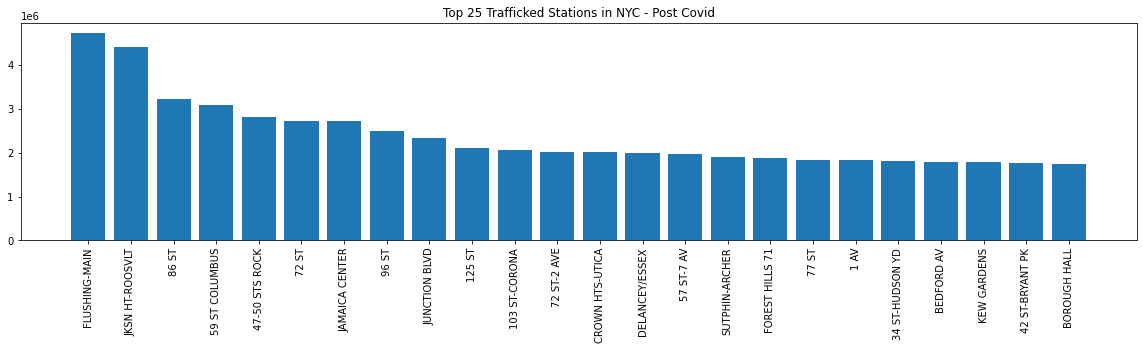

In [112]:
plt.figure(figsize=(20,4)) 


plt.xticks(rotation='vertical')
plt.bar(post_MTA_Top25['STATION'], post_MTA_Top25['DAILY_ENTRIES'])
plt.title('Top 25 Trafficked Stations in NYC - Post Covid')

# Comparison Data
Create new dataframe to compare the changes from 2019 data to 2021 data. 

In [113]:
#Merges the two filtered data frames of pre- and post-covid station data into one data frame using an inner join
df_merge = pd.merge(pre_daily_station_filtered , post_daily_station_filtered, on = ['STATION' , 'LINENAME'] , how='inner')
df_merge.head()

,STATION,LINENAME,DAILY_ENTRIES_x,ENTRIES_x,Borough,DAILY_ENTRIES_y,ENTRIES_y
0,1 AV,L,"3,109,217.0","14,471,608.0",M,"1,831,366.0","15,532,793.0"
1,103 ST,1,"2,091,736.0","1,798,471.0",M,"878,663.0","37,854.0"
2,103 ST,6,"2,316,813.0","36,655,681.0",M,"984,563.0","943,158.0"
3,103 ST,BC,"899,196.0","13,967,624.0",M,"318,983.0","14,912,538.0"
4,103 ST-CORONA,7,"3,677,694.0","15,470,589.0",Q,"2,066,141.0","16,354,845.0"


In [114]:
#Create a new column that calculates the % change from pre-covid traffic to post-covid traffic
df_merge['CHANGE'] = (df_merge['DAILY_ENTRIES_y'] - df_merge['DAILY_ENTRIES_x'] ) / df_merge['DAILY_ENTRIES_x']  * 100

#Round it to two decimal points for easier viewing
df_merge['CHANGE'] = df_merge['CHANGE'].round(2)

STATION             object
LINENAME            object
DAILY_ENTRIES_x    float64
ENTRIES_x          float64
Borough             object
DAILY_ENTRIES_y    float64
ENTRIES_y          float64
CHANGE             float64
dtype: object

In [115]:
df_merge.sort_values(by = ['CHANGE'] , ascending = False).head(50)

,STATION,LINENAME,DAILY_ENTRIES_x,ENTRIES_x,Borough,DAILY_ENTRIES_y,ENTRIES_y,CHANGE
156,ASTORIA BLVD,NQW,"130,171.0","6,478,005.0",Q,"845,325.0","6,572,220.0",549.4
10,111 ST,J,"162,828.0","3,744,683.0",Q,"190,427.0","3,938,689.0",16.95
398,TOMPKINSVILLE,1,"256,051.0","576,891.0",SI,"278,123.0","637,944.0",8.62
38,168 ST,1AC,"997,474.0","294,241.0",M,"938,437.0","401,067.0",-5.92
260,FLUSHING AV,G,"395,944.0","528,501.0",Bk,"330,647.0","632,866.0",-16.49
62,215 ST,1,"305,041.0","181,902.0",M,"238,886.0","420,257.0",-21.69
167,AVENUE U,N,"608,353.0","3,828,820.0",Bk,"436,836.0","4,144,718.0",-28.19
180,BEACH 60 ST,A,"370,128.0","3,036,315.0",Q,"263,355.0","140,496.0",-28.85
159,AVENUE H,BQ,"899,568.0","663,519.0",Bk,"632,928.0","38,266.0",-29.64
310,KINGS HWY,N,"891,522.0","4,225,967.0",Bk,"617,586.0","4,494,421.0",-30.73


In [92]:
#Std Dev across all changes
df_merge['CHANGE'].std()

31.407977377218575

In [93]:
#Average across all changes
df_merge['CHANGE'].mean()

-55.989245283018946

Text(0.5, 1.0, 'Average % Decrease in Station Traffic by Borough')

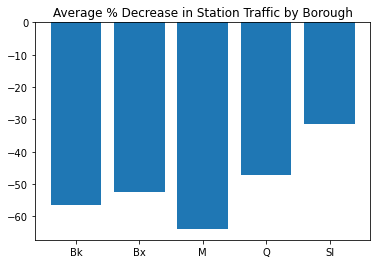

In [116]:
#Create dataframe df_borough to compare change % between boroughs.
df_borough = df_merge.groupby('Borough' , as_index = False).CHANGE.mean()

plt.bar(df_borough['Borough'],df_borough['CHANGE'])
plt.title('Average % Decrease in Station Traffic by Borough')
